<a href="https://colab.research.google.com/github/Priyanshu7tiwary/ML/blob/main/test_pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

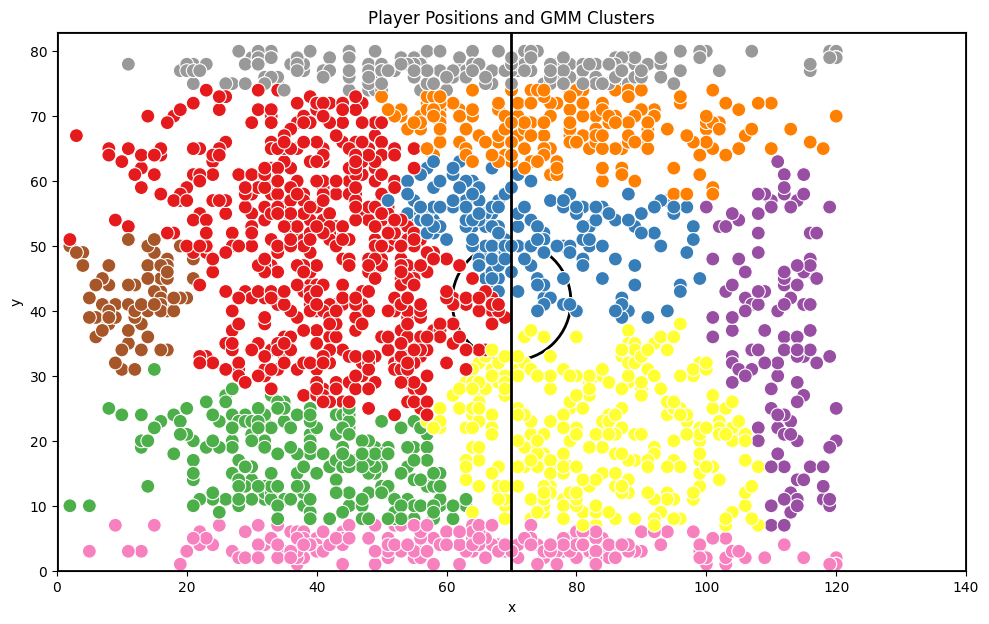

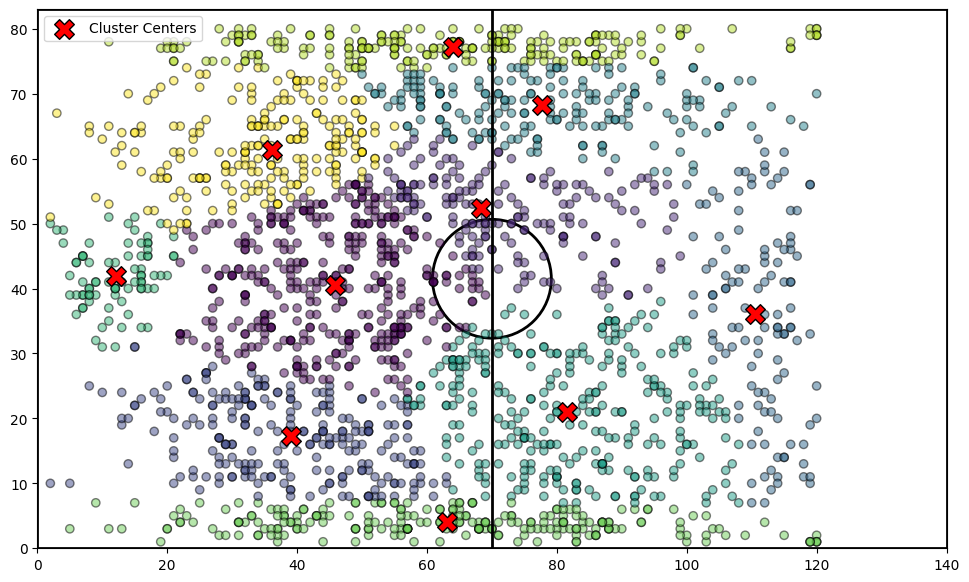

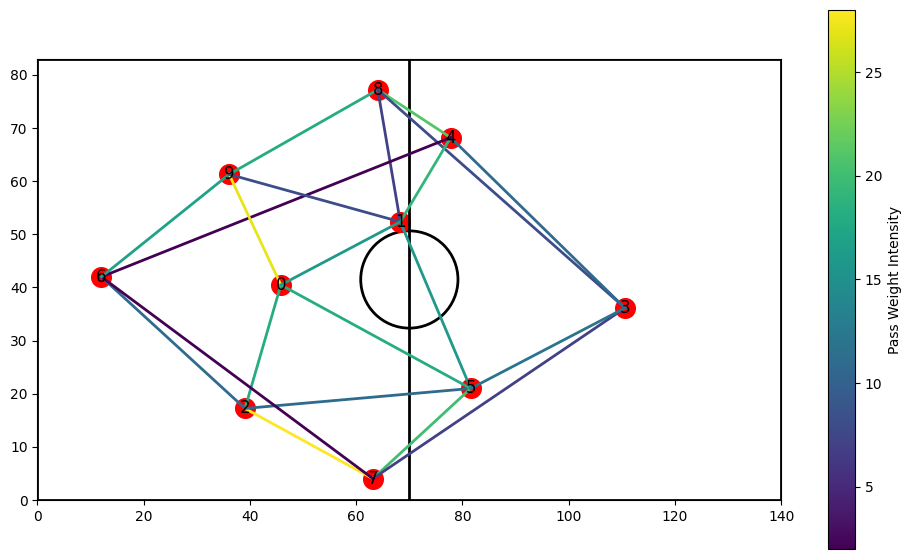

In [6]:
# Install necessary libraries
!pip install mplsoccer statsbombpy pandas matplotlib seaborn scikit-learn networkx

import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np
import networkx as nx
from statsbombpy import sb

# Fetch match data
matches = sb.matches(competition_id=11, season_id=1)
match_id = matches[(matches['home_team'] == 'Real Madrid') & (matches['away_team'] == 'Barcelona')].iloc[0]['match_id']
events = sb.events(match_id=match_id)

# Filter substitutions and passes
subs = events[events['type'] == 'Substitution']
passes = events[events['type'] == 'Pass']

# Save to CSV (optional)
subs.to_csv('match_subs.csv', index=False)
passes.to_csv('match_passes.csv', index=False)

# Load passes data
passes = pd.read_csv('match_passes.csv')

# Select relevant columns
selected_columns = ['location', 'pass_end_location', 'pass_recipient_id', 'player_id', 'timestamp']
df = passes[selected_columns]

# Extract start and end locations
start_locations = df['location']
end_locations = df['pass_end_location']

# Convert string representations of lists to actual lists
start_locations = start_locations.apply(ast.literal_eval)
end_locations = end_locations.apply(ast.literal_eval)

# Create DataFrame for start locations
start_df = pd.DataFrame(start_locations.tolist(), columns=['start_x', 'start_y'])

# Create DataFrame for end locations
end_df = pd.DataFrame(end_locations.tolist(), columns=['end_x', 'end_y'])

# Combine start and end locations into a single DataFrame
combined_df = pd.concat([start_df, end_df], axis=1)

# Combine all coordinates for clustering
all_coordinates = pd.concat([start_locations, end_locations], axis=0, ignore_index=True)
all_coordinates = pd.DataFrame(all_coordinates.tolist(), columns=['x', 'y'])
X = all_coordinates[['x', 'y']].values

# Fit Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10)
gmm.fit(X)
labels = gmm.predict(X)

# Fit KMeans clustering

cluster_centers = gmm.means_


# Add cluster labels to the combined DataFrame
combined_df['start_cluster'] =gmm.predict(combined_df[['start_x', 'start_y']])
combined_df['end_cluster'] = gmm.predict(combined_df[['end_x', 'end_y']])

# Create weighted edges
weighted_edges = combined_df.groupby(['start_cluster', 'end_cluster']).size().reset_index(name='weight')

# Plot football pitch
def plot_pitch():
    fig, ax = plt.subplots(figsize=(12, 7))
    pitch_length = 140
    pitch_width = 83

    # Draw pitch boundaries
    ax.plot([0, 0], [0, pitch_width], color="black", lw=2)
    ax.plot([0, pitch_length], [pitch_width, pitch_width], color="black", lw=2)
    ax.plot([pitch_length, pitch_length], [pitch_width, 0], color="black", lw=2)
    ax.plot([pitch_length, 0], [0, 0], color="black", lw=2)

    # Draw halfway line
    ax.plot([pitch_length / 2, pitch_length / 2], [0, pitch_width], color="black", lw=2)

    # Draw center circle
    center_circle = plt.Circle((pitch_length / 2, pitch_width / 2), 9.15, color='black', fill=False, lw=2)
    ax.add_patch(center_circle)

    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)
    ax.set_aspect('equal')
    return ax

# Plot clusters
ax = plot_pitch()
sns.scatterplot(data=all_coordinates, x='x', y='y', hue=labels, palette='Set1', ax=ax, s=100, legend=None)
plt.title('Player Positions and GMM Clusters')
plt.show()

# Plot cluster centers
ax = plot_pitch()
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5, edgecolors="k")
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=200, edgecolors="black", label="Cluster Centers")
plt.legend()
plt.show()

# Create network graph
G = nx.Graph()
sorted_edges = weighted_edges.sort_values(by='weight', ascending=False)
edge_count = {i: 0 for i in range(len(cluster_centers))}

for _, row in sorted_edges.iterrows():
    start, end = row['start_cluster'], row['end_cluster']
    if start != end and edge_count[start] < 6 and edge_count[end] < 6:
        G.add_edge(start, end, weight=row['weight'])
        edge_count[start] += 1
        edge_count[end] += 1

# Plot network graph on pitch
ax = plot_pitch()
for i, (x, y) in enumerate(cluster_centers):
    plt.scatter(x, y, color='red', s=200)
    plt.text(x, y, str(i), fontsize=12, color='black', ha='center', va='center')

weights = [edge[2]['weight'] for edge in G.edges(data=True)]
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.viridis

for edge in G.edges(data=True):
    start, end, weight = edge
    x_start, y_start = cluster_centers[start]
    x_end, y_end = cluster_centers[end]
    color = cmap(norm(weight['weight']))
    plt.plot([x_start, x_end], [y_start, y_end], 'k-', lw=2, color=color)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Pass Weight Intensity')
plt.show()